In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
from scipy import stats
pd.set_option('display.max_columns', None)
from scipy.stats import skew, kurtosis
from itertools import product
import warnings
warnings.filterwarnings("ignore")
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
#Read zipcode_shapefiles

chunk_size = 50000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 300000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

In [28]:
def create_union_and_flag(df, year_1, year_2, new_year):
    df_year_1 = df[df['year'] == year_1]
    df_year_2 = df[df['year'] == year_2]

    new_geometries = []

    unique_zipcodes = set(df_year_1['ZIPcode']).union(df_year_2['ZIPcode'])

    for zipcode in unique_zipcodes:
        geom_year_1 = df_year_1.loc[df_year_1['ZIPcode'] == zipcode, 'geometry'].unary_union if zipcode in df_year_1['ZIPcode'].values else None
        geom_year_2 = df_year_2.loc[df_year_2['ZIPcode'] == zipcode, 'geometry'].unary_union if zipcode in df_year_2['ZIPcode'].values else None

        if geom_year_1 is not None and geom_year_2 is not None:
            new_geometry = unary_union([geom_year_1, geom_year_2])
            flag = None
        elif geom_year_1 is not None:
            new_geometry = geom_year_1
            flag = f'only{year_1}'
        elif geom_year_2 is not None:
            new_geometry = geom_year_2
            flag = f'only{year_2}'
        else:
            continue

        new_geometries.append({'ZIPcode': zipcode, 'geometry': new_geometry, 'year': new_year, 'flag': flag})

    return new_geometries

In [29]:
new_geometries_2011 = create_union_and_flag(zipcode_df, 2010, 2012, 2011)
zipcode_df_1 = gpd.GeoDataFrame(new_geometries_2011)

In [30]:
zipcode_df_1.head()

,ZIPcode,geometry,year,flag
0,10022,"POLYGON ((-73.96773 40.76285, -73.96613 40.762...",2011,None
1,68073,"POLYGON ((-96.42585 41.32854, -96.42601 41.328...",2011,None
2,77091,"POLYGON ((-95.46101 29.84101, -95.46304 29.841...",2011,None
3,84537,"POLYGON ((-111.21896 39.37398, -111.21913 39.3...",2011,None
4,22312,"POLYGON ((-77.17221 38.79154, -77.17232 38.791...",2011,None


In [31]:
zipcode_df_1[zipcode_df_1['flag']=='only2012'].shape[0]

21

In [32]:
zipcode_df_1.shape[0]

22515

# Visualization

Plotting data for year 2010 - Area: 0.001449191893999998
Plotting data for year 2011 - Area: 0.0014518045408605568
Plotting data for year 2012 - Area: 0.0014516580280000153


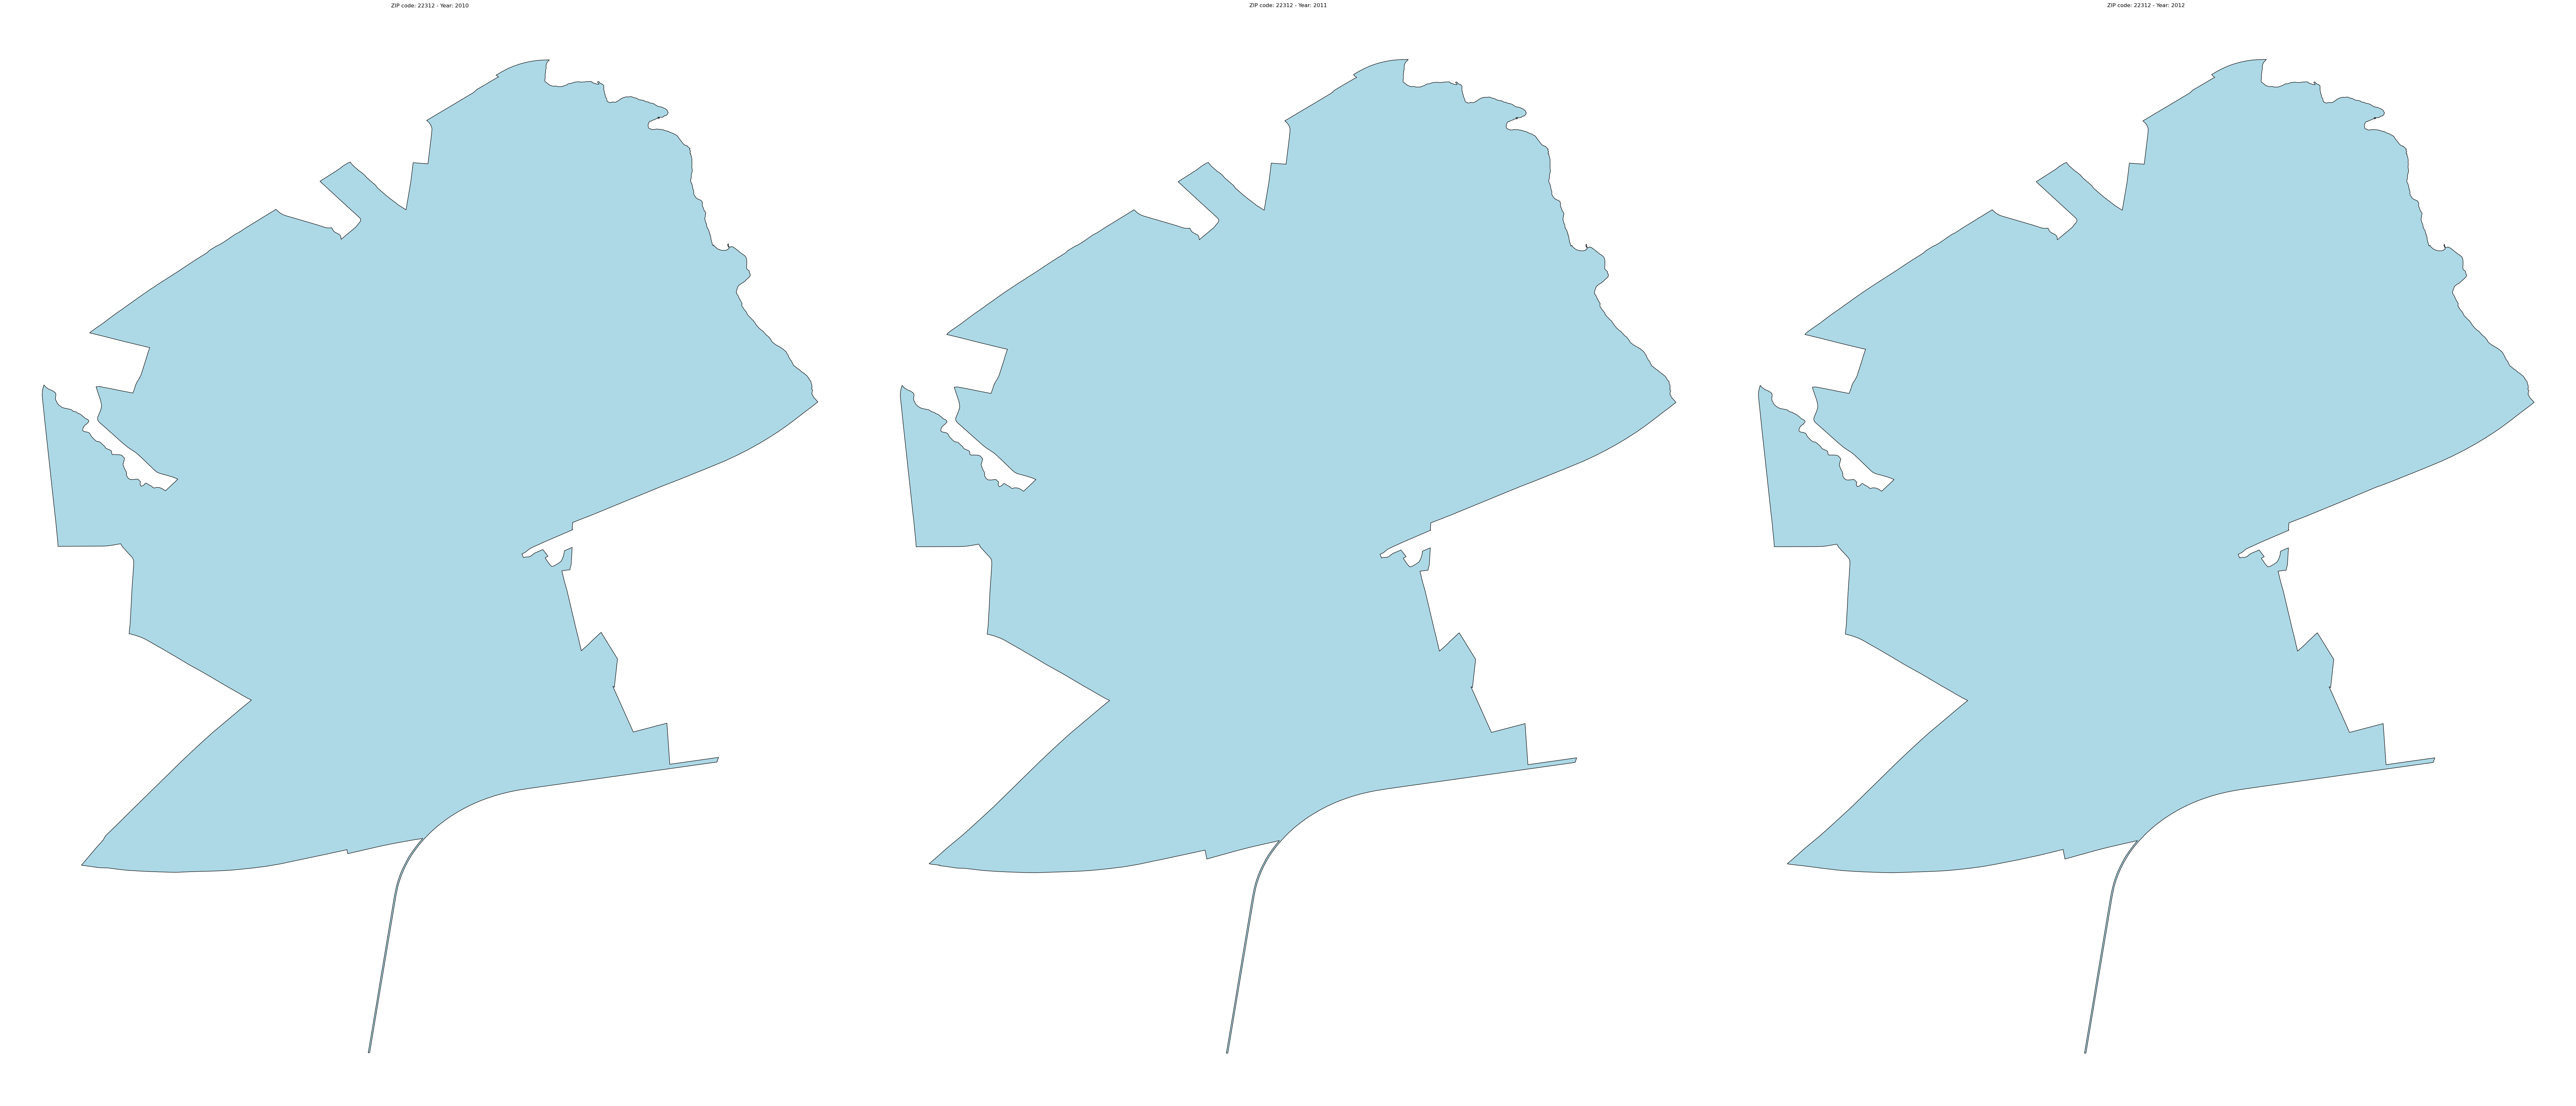

In [34]:
target_zipcode = '22312'
target_years = [2010, 2011, 2012]

fig, axes = plt.subplots(1, 3, figsize=(80, 65))

for i, year in enumerate(target_years):
    if year == 2011:
        data = zipcode_df_1[(zipcode_df_1['ZIPcode'] == target_zipcode) & (zipcode_df_1['year'] == year)]
    else:
        data = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == year)]

    if not data.empty:
        # Calculate the area using the geometry column
        area = data['geometry'].area
        print(f"Plotting data for year {year} - Area: {area.iloc[0]}")
        
        # Plot the geometry
        data.plot(ax=axes[i], color='lightblue', edgecolor='black')
    else:
        print(f"No data for year {year}")

    axes[i].set_title(f'ZIP code: {target_zipcode} - Year: {year}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Saving the shapefile

In [35]:
zipcode_df_1['geometry'] = zipcode_df_1['geometry'].apply(lambda geom: geom.wkt)
zipcode_df_1.to_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_2011_union.parquet.gzip", compression='gzip')